## Практическое задание

1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import math
from IPython import display
# from torchvision.utils import save_image, make_grid

In [87]:
# сгенерируем данные точек

x = np.linspace(0.001, 20, 10000)
y = np.sin(x)/x - x/10

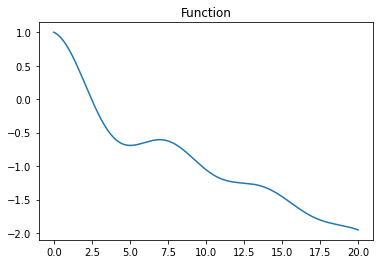

In [88]:
# визуализируем функцию

plt.title('Function')
plt.plot(x, y)
plt.show()

In [89]:
# проверим устройство

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## **Dataset**

In [90]:
# класс для создания кастомного датасета 

class MyDataset(Dataset):

    def __init__(self, length=10000):
        self.data_xy = torch.zeros((length, 2))
        self.data_xy[:, 0] = torch.FloatTensor(np.linspace(0.001, 20, length))
        self.data_xy[:, 1] = torch.FloatTensor(np.sin(self.data_xy[:, 0])/self.data_xy[:, 0] - self.data_xy[:, 0]/10)

    def __len__(self):        
        return self.data_xy.shape[0]

    def __getitem__(self, index):
        data_xy = self.data_xy[index]

        return data_xy

In [91]:
data_train = MyDataset()

In [92]:
# посмотрим на единичные экземпляры

data_train[10]

tensor([0.0210, 0.9978])

In [93]:
print(f'Train length: {len(data_train)}')

Train length: 10000


In [94]:
BATCH_SIZE = 128

# размерность случайного вектора, который подается на вход генератору
LATENT_DIM = 100

# количество эпох
N_EPOCHS = 500 

# количество итераций для отображения процесса обучения
SAMPLE_INTERVAL = 500  

# шаг обучения
LR = 0.001 

# гиперпараметры для оптимайзера Adam
B1 = 0.5  
B2 = 0.999  

In [95]:
# сформируем батчи

data_train_loader = torch.utils.data.DataLoader(data_train, 
                                                batch_size=BATCH_SIZE, # увеличить батчи
                                                shuffle=True,
                                                num_workers=2, 
                                                drop_last=True)

print(f'Number of train batches: {len(data_train_loader)}')

Number of train batches: 78


In [96]:
# посмотрим на тензоры
for data in data_train_loader:
    print(data.shape)
    # print(data)
    break

torch.Size([128, 2])


## **Generator**

In [97]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            # layers.append(nn.Dropout(0.2))
            return layers

        self.model = nn.Sequential(
            *block(LATENT_DIM, 128, normalize=False),  # Звездочка означает unpacking списка  
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        points = self.model(z)
        return points

## **CustomLinearLayer**

In [98]:
class CustomLinearLayer(nn.Module):
  
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные 
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())

        return torch.add(w_times_x, self.bias)  

In [99]:
layer = CustomLinearLayer(1, 2)
layer.weights, layer.bias

(Parameter containing:
 tensor([[-0.0026],
         [ 0.0030]], requires_grad=True), Parameter containing:
 tensor([-0.0018, -0.0031], requires_grad=True))

## **Discriminator**

In [100]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )  

    def forward(self, points):
        validity = self.model(points)
        return validity

## **Parameters**

In [101]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=LR, 
    betas=(B1, B2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=LR, 
    betas=(B1, B2)
)

# функция ошибки
adversarial_loss = torch.nn.BCELoss()
# adversarial_loss_g = torch.nn.MSELoss()

In [102]:
d_loss_history = []
g_loss_history = []

In [103]:
# функция для вывода и сохранения изображения

def sample_data(data):
  
    plt.scatter(xy[:, 0].cpu().numpy(), xy[:, 1].cpu().numpy())
    plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy())
    plt.show()

## **Learning**

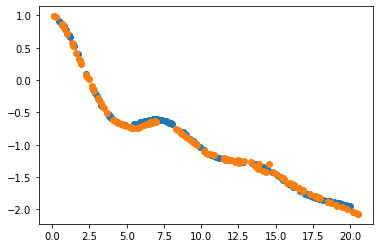

[Epoch 493/500] [Batch 46/78]|[D loss: 0.6954379081726074] [G loss: 0.9962599873542786]


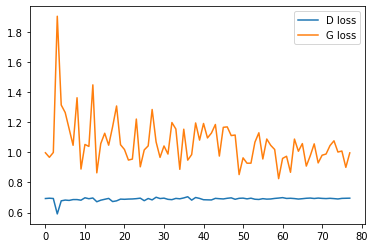

In [104]:
import matplotlib.patches as mpatches


for epoch in range(N_EPOCHS):
    for i, xy in enumerate(data_train_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0).to(device)

        real_xy = xy.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_xy = generator(z)
  
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_xy)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_xy)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_xy = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_xy)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)/adversarial_loss(fake_pred, fake)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(data_train_loader) + i
    
        if batches_done % SAMPLE_INTERVAL == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_data(gen_xy)
                print(f"[Epoch {epoch}/{N_EPOCHS}] [Batch {i}/{len(data_train_loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                # display.display(plt.gcf())
                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()        

In [105]:
latent_space_samples = torch.randn(100, LATENT_DIM).to(device)
generated_samples = generator(latent_space_samples)

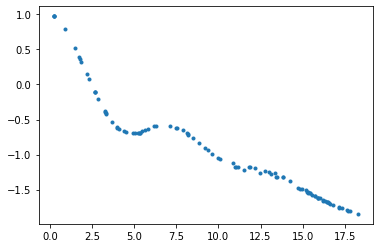

In [106]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0].cpu(), generated_samples[:, 1].cpu(), ".")

In [107]:
# https://realpython.com/generative-adversarial-networks/#further-reading